In [52]:
import pandas as pd
import numpy as np
import sklearn as sk

In [53]:
df = pd.read_csv('Data/ListaCobroDetalle2025.csv')
# Ordernar por idCredito
df = df.sort_values(by=['idCredito'])
# Eliminar la fecha de cobro banco
df = df.drop(columns=['fechaCobroBanco'])
# Rellenar los nulos con 0
df = df.fillna(0)
print (df.shape)
df.head()
# Para cada idCredito, restar el consecutivoCobro mínimo de ese grupo para que el orden inicie en 0

# Enumerar en base al índice del valor para cada idCredito
df['orden'] = df.groupby('idCredito').cumcount()
print(df.shape)
print(df.head(10))
# Filtra los valores a los 4 mas populares y si no esta dentro de esos 4, lo pone como otro o 1
top4_bancos = df['idBanco'].value_counts().nlargest(4).index
print (top4_bancos) # son 12, 2, 72, 21
# Hacer un diccionario de los 4 bancos mas populares de 0 a 3
# y el resto como 4
bancos = {12: 0, 2: 1, 72: 2, 21: 3}
# Agregamos el resto como 4
bancos.update({x: 4 for x in df['idBanco'].unique() if x not in bancos})
df['idBanco'] = df['idBanco'].apply(lambda x: x if x in top4_bancos else 1)
# Ahora la pasamos a dummy
df = pd.get_dummies(df, columns=['idBanco'], prefix='banco')

print (df.head())
print (df.shape)

(2114172, 8)
(2114172, 9)
        idListaCobro  idCredito  consecutivoCobro  idBanco  montoExigible  \
27854         156277       9872          41468078        2        969.200   
112144        156458       9872          41558280        2        969.200   
223989        156727       9872          41691792        2        484.600   
160606        156566       9872          41613223        2        969.200   
221225        156711       9872          41688488        2        484.600   
195200        156625       9872          41656948        2        484.600   
142186        156525       9872          41593527        2        969.200   
216330        156692       9872          41684150        2        484.600   
181888        156602       9872          41641011        2        969.200   
80002         156378       9872          41524210        2        969.200   

        montoCobrar  montoCobrado  idRespuestaBanco  orden  
27854       969.200         0.000             4.000      0  
1121

In [ ]:
# Quitamos valores que no son necesarios
# idListaCobro  idCredito  consecutivoCobro
df_c = df.drop(columns=['idListaCobro', 'idCredito', 'consecutivoCobro'])

In [55]:
# Aplicar un pca a los datos
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# Seleccionar las columnas numéricas para PCA
numeric_cols = df_c.select_dtypes(include=[np.number]).columns.tolist()
# Aplicar PCA
pca_result = pca.fit_transform(df_c[numeric_cols])

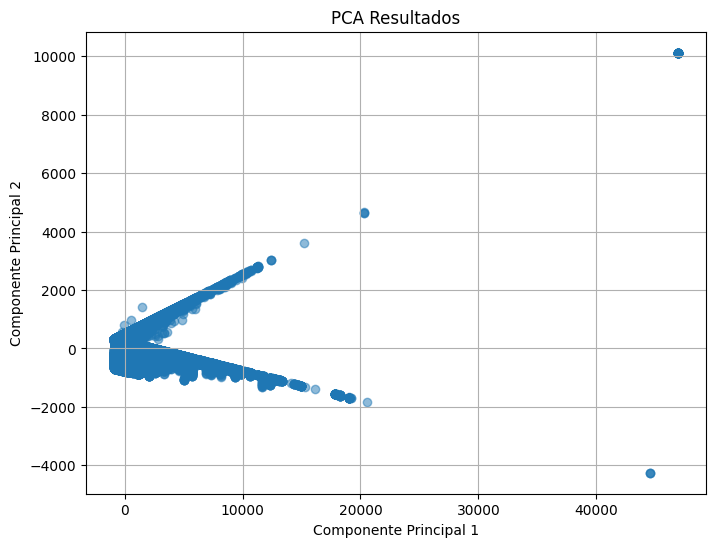

In [56]:
# Visualizar los resultados del PCA
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA Resultados')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()
plt.show()

In [65]:
# Haz un k-means clustering con 4 clusters
from sklearn.cluster import DBSCAN
kmeans = DBSCAN(eps=0.5, min_samples=5)
# Ajustar el modelo
kmeans.fit(pca_result)
# Agregar las etiquetas de cluster al DataFrame original
df['cluster'] = kmeans.labels_
# Mostrar los primeros 10 registros con las etiquetas de cluster
print(df.head(10))

        idListaCobro  idCredito  consecutivoCobro  montoExigible  montoCobrar  \
27854         156277       9872          41468078        969.200      969.200   
112144        156458       9872          41558280        969.200      969.200   
223989        156727       9872          41691792        484.600      484.600   
160606        156566       9872          41613223        969.200      969.200   
221225        156711       9872          41688488        484.600      484.600   
195200        156625       9872          41656948        484.600      484.600   
142186        156525       9872          41593527        969.200      969.200   
216330        156692       9872          41684150        484.600      484.600   
181888        156602       9872          41641011        969.200      969.200   
80002         156378       9872          41524210        969.200      969.200   

        montoCobrado  idRespuestaBanco  orden  banco_1  banco_2  banco_12  \
27854          0.000           

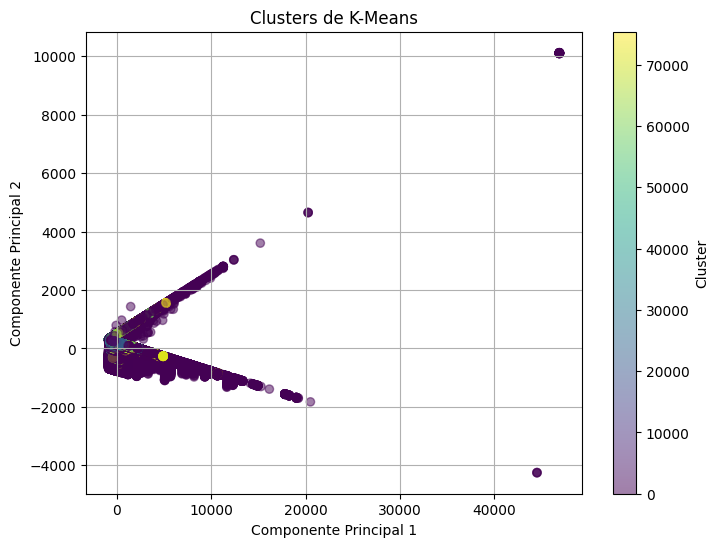

In [66]:
# Visualizar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters de K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

In [59]:
# Ahora por monto a pagar, o sea montoExigible
# Agrupar por cluster y calcular la suma de montoExigible
cluster_monto = df.groupby('cluster')['montoExigible'].sum()
# Mostrar la tabla de montos con todos los digitos
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(cluster_monto)

cluster
0   489852819.840
1   284546551.430
2   460676267.700
3    79037106.810
Name: montoExigible, dtype: float64


In [64]:
# Ahora un clustering por idRespuestaBanco
# Agrupamos por cluster y luego por idRespuestaBanco y vemos las proporciones
cluster_respuesta = df.groupby(['cluster', 'idRespuestaBanco']).size().unstack(fill_value=0)
# Calcular las proporciones
cluster_respuesta_prop = cluster_respuesta.div(cluster_respuesta.sum(axis=0), axis=1)
# Mostrar la tabla de proporciones
print(cluster_respuesta_prop)

idRespuestaBanco  0.000   1.000   2.000   3.000   4.000   6.000   8.000   \
cluster                                                                    
0                  0.504   0.462   0.606   0.555   0.720   1.000   0.574   
1                  0.122   0.119   0.074   0.146   0.061   0.000   0.093   
2                  0.363   0.399   0.309   0.276   0.212   0.000   0.327   
3                  0.011   0.021   0.011   0.023   0.007   0.000   0.006   

idRespuestaBanco  10.000  13.000  26.000  30.000  36.000  40.000  88.000  
cluster                                                                   
0                  0.500   0.721   0.529   0.659   0.182   0.091   0.167  
1                  0.000   0.055   0.137   0.012   0.000   0.000   0.333  
2                  0.500   0.216   0.318   0.232   0.818   0.909   0.333  
3                  0.000   0.007   0.016   0.098   0.000   0.000   0.167  
